# Heart Failure Diagnosis

**Heart Failure Prediction – End-to-End ML Pipeline (XGBoost + SHAP)**

**Author:** João Gustavo Borges e Souza
**Date:** 2025-10

### 1. Introduction <a id="introduction"></a>

**Objective:**  
Develop and evaluate a machine learning model to predict the presence of cardiovascular disease (`cardio`, 1 = disease, 0 = no disease) using routine clinical and lifestyle features.  
The final output is an interpretable and deployable model built with XGBoost.

**Why this matters?**  
Cardiovascular disease remains one of the leading global causes of mortality.  
Accurate risk prediction based on standard health metrics (blood pressure, cholesterol, glucose, etc.) can support early detection and preventive care in clinical settings.

### Dictionary of Variables

* `id` - Unique identifier for each patient record. 

* `age` - Age of the patient in days

* `gender` - Biological sex of the patient (1 = Female, 2 = Male).

* `height` - Height of the patient in centimeters.

* `weight` - Weight of the patient in kilograms.

* `ap_hi` - Systolic blood pressure (higher reading).

* `ap_lo` - Diastolic blood pressure (lower reading).

* `cholesterol` - Cholesterol level (1 = normal, 2 = above normal, 3 = well above normal).

* `gluc` - Glucose level (1 = normal, 2 = above normal, 3 = well above normal).

* `smoke` - Smoking status (1 = smoker, 0 = non-smoker).

* `alco` - Alcoholic status (1 = alcoholic, 0 = non-alcoholic)

* `active` - Physical activity (1 = active, 0 = inactive)

* `cardio` - Heart disease (1 = disease present, 0 = disease absent)

In [7]:
# import necessary libraries
import os, json, joblib, warnings, datetime
warnings.filterwarnings("ignore")

# libraries for data manipulation
import numpy as np
import pandas as pd
from pathlib import Path

# libraries for model building, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# libraries for data visualization
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import seaborn as sns
sns.set_theme(style="dark")


PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PATH = PROJECT_ROOT / "data" / "raw" / "HeartFailureDataset.csv"
MODEL_PATH = PROJECT_ROOT / "models" / f"heart_model{datetime.date.today()}.pkl"
META_PATH  = PROJECT_ROOT / "models" / "model_meta.json"

PROJECT_ROOT, DATA_PATH, MODEL_PATH

(PosixPath('/Users/joaogustavoborgesesouza/Documents/Heart_disease/HeartFailure-Diagnosis-Api'),
 PosixPath('/Users/joaogustavoborgesesouza/Documents/Heart_disease/HeartFailure-Diagnosis-Api/data/raw/HeartFailureDataset.csv'),
 PosixPath('/Users/joaogustavoborgesesouza/Documents/Heart_disease/HeartFailure-Diagnosis-Api/models/heart_model2025-10-26.pkl'))

### 2. Dataset & Features 

We briefly sanity-check shapes, types, and target balance.
No encoding or scaling is required; all features are numeric. We’ll drop only identifiers (id) if not predictive.

In [8]:
# read dataset
df = pd.read_csv(DATA_PATH)

In [9]:
# inspect dataset
print(f"Dimensions: {df.shape}")
df.head()

Dimensions: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62,110,80,1,1,0,0,1,0
1,1,20228,1,156,85,140,90,3,1,0,0,1,1
2,2,18857,1,165,64,130,70,3,1,0,0,0,1
3,3,17623,2,169,82,150,100,1,1,0,0,1,1
4,4,17474,1,156,56,100,60,1,1,0,0,0,0


In [10]:
# inspect dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           70000 non-null  int64
 1   age          70000 non-null  int64
 2   gender       70000 non-null  int64
 3   height       70000 non-null  int64
 4   weight       70000 non-null  int64
 5   ap_hi        70000 non-null  int64
 6   ap_lo        70000 non-null  int64
 7   cholesterol  70000 non-null  int64
 8   gluc         70000 non-null  int64
 9   smoke        70000 non-null  int64
 10  alco         70000 non-null  int64
 11  active       70000 non-null  int64
 12  cardio       70000 non-null  int64
dtypes: int64(13)
memory usage: 6.9 MB


In [11]:
# inspect dataset statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205543,14.395829,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817714,154.011381,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [12]:
# Check for missing values
print(f'Percentage of missing values:\t\n{df.isnull().sum() / df.shape[0]}')

Percentage of missing values:	
id             0.0
age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
cardio         0.0
dtype: float64


In [13]:
# create a copy of the original dataframe
df_clean = df.copy()

In [14]:
# drop 'id' column as it is not useful for modeling
df_clean.drop(columns=["id"], inplace=True)

In [15]:
# converting age of day to years
df_clean['age'] = df_clean['age'] // 365 

### 3. EDA – What to look for 

#### **Feature Distributions (Univariate)** 

Most variables show expected clinical patterns:  
- **Age** follows an approximately uniform distribution between 35–65 years.  
- **Height** and **weight** resemble normal distributions, indicating no major sampling bias.  
- **ap_hi** and **ap_lo** (blood pressure readings) are right-skewed, with occasional extreme values that could reflect measurement or entry errors.  
- **cholesterol** and **gluc** exhibit discrete peaks at coded levels (1–3), consistent with categorical scaling.  
- Lifestyle flags (**smoke**, **alco**, **active**) are binary and mostly concentrated at 0 (non-smoker, non-alcoholic, active).  

→ Overall, no strong imbalance or missing information is apparent. Minor outliers in blood pressure may warrant winsorization or inspection if we were doing clinical deployment.

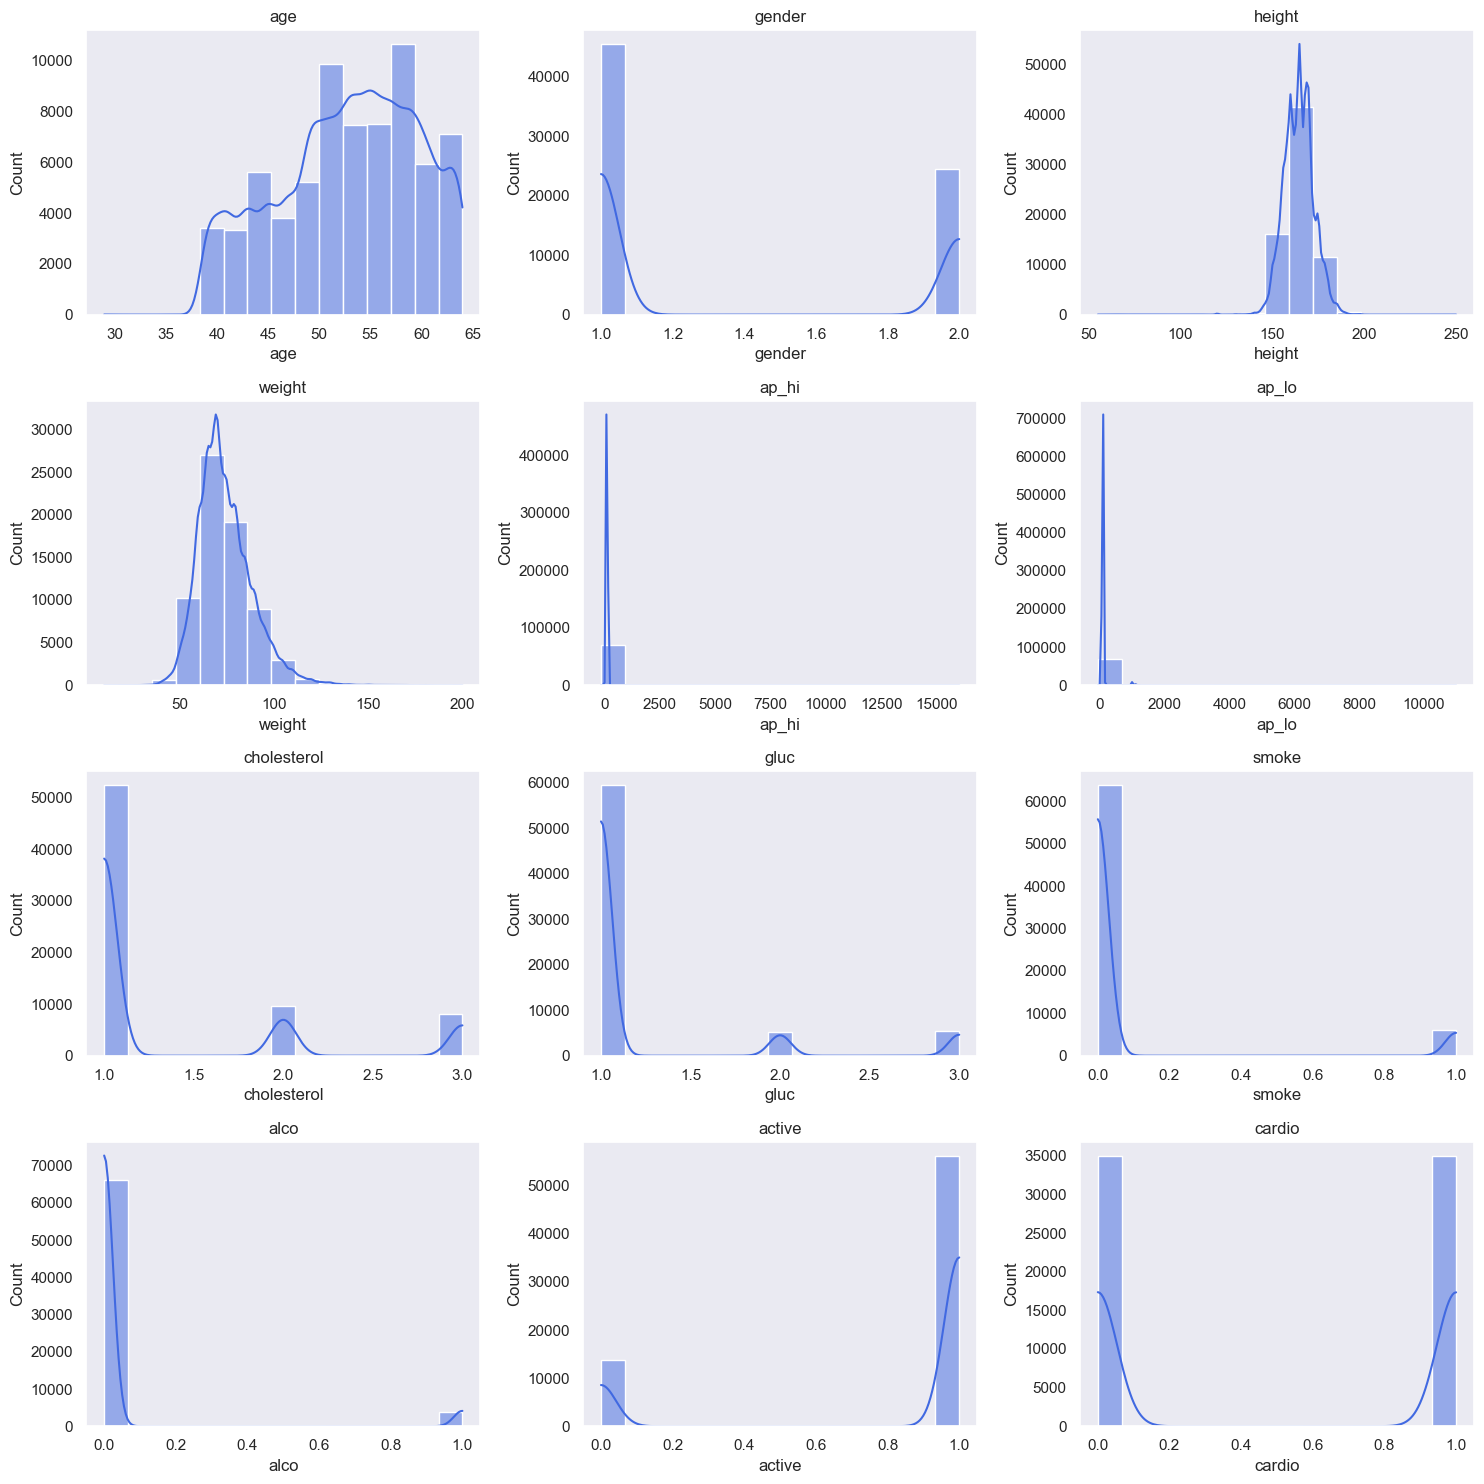

In [16]:
# visualize distributions of features
cols = df_clean.columns.tolist()

fig, axes = plt.subplots(nrows=len(cols) // 3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df_clean[col], bins=15, ax=axes[i], kde=True, color="royalblue")
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

#### **Class-wise distributions (cardio = 0/1)**  
Overlaying each feature by target class highlights the strongest separations:  
- **Age:** patients with cardiovascular disease are generally older.  
- **ap_hi/ap_lo:** both shifted to higher values for diseased cases.  
- **Cholesterol:** higher codes (2–3) more common among positive cases.  
- **Weight:** slightly higher mean for disease class, though overlap is large.  
- **Lifestyle factors:** show minimal separation — smoking, alcohol, and activity seem weakly related in this dataset.  

→ The clearest predictive signals come from **blood pressure**, **age**, and **cholesterol**, which aligns with established medical evidence.

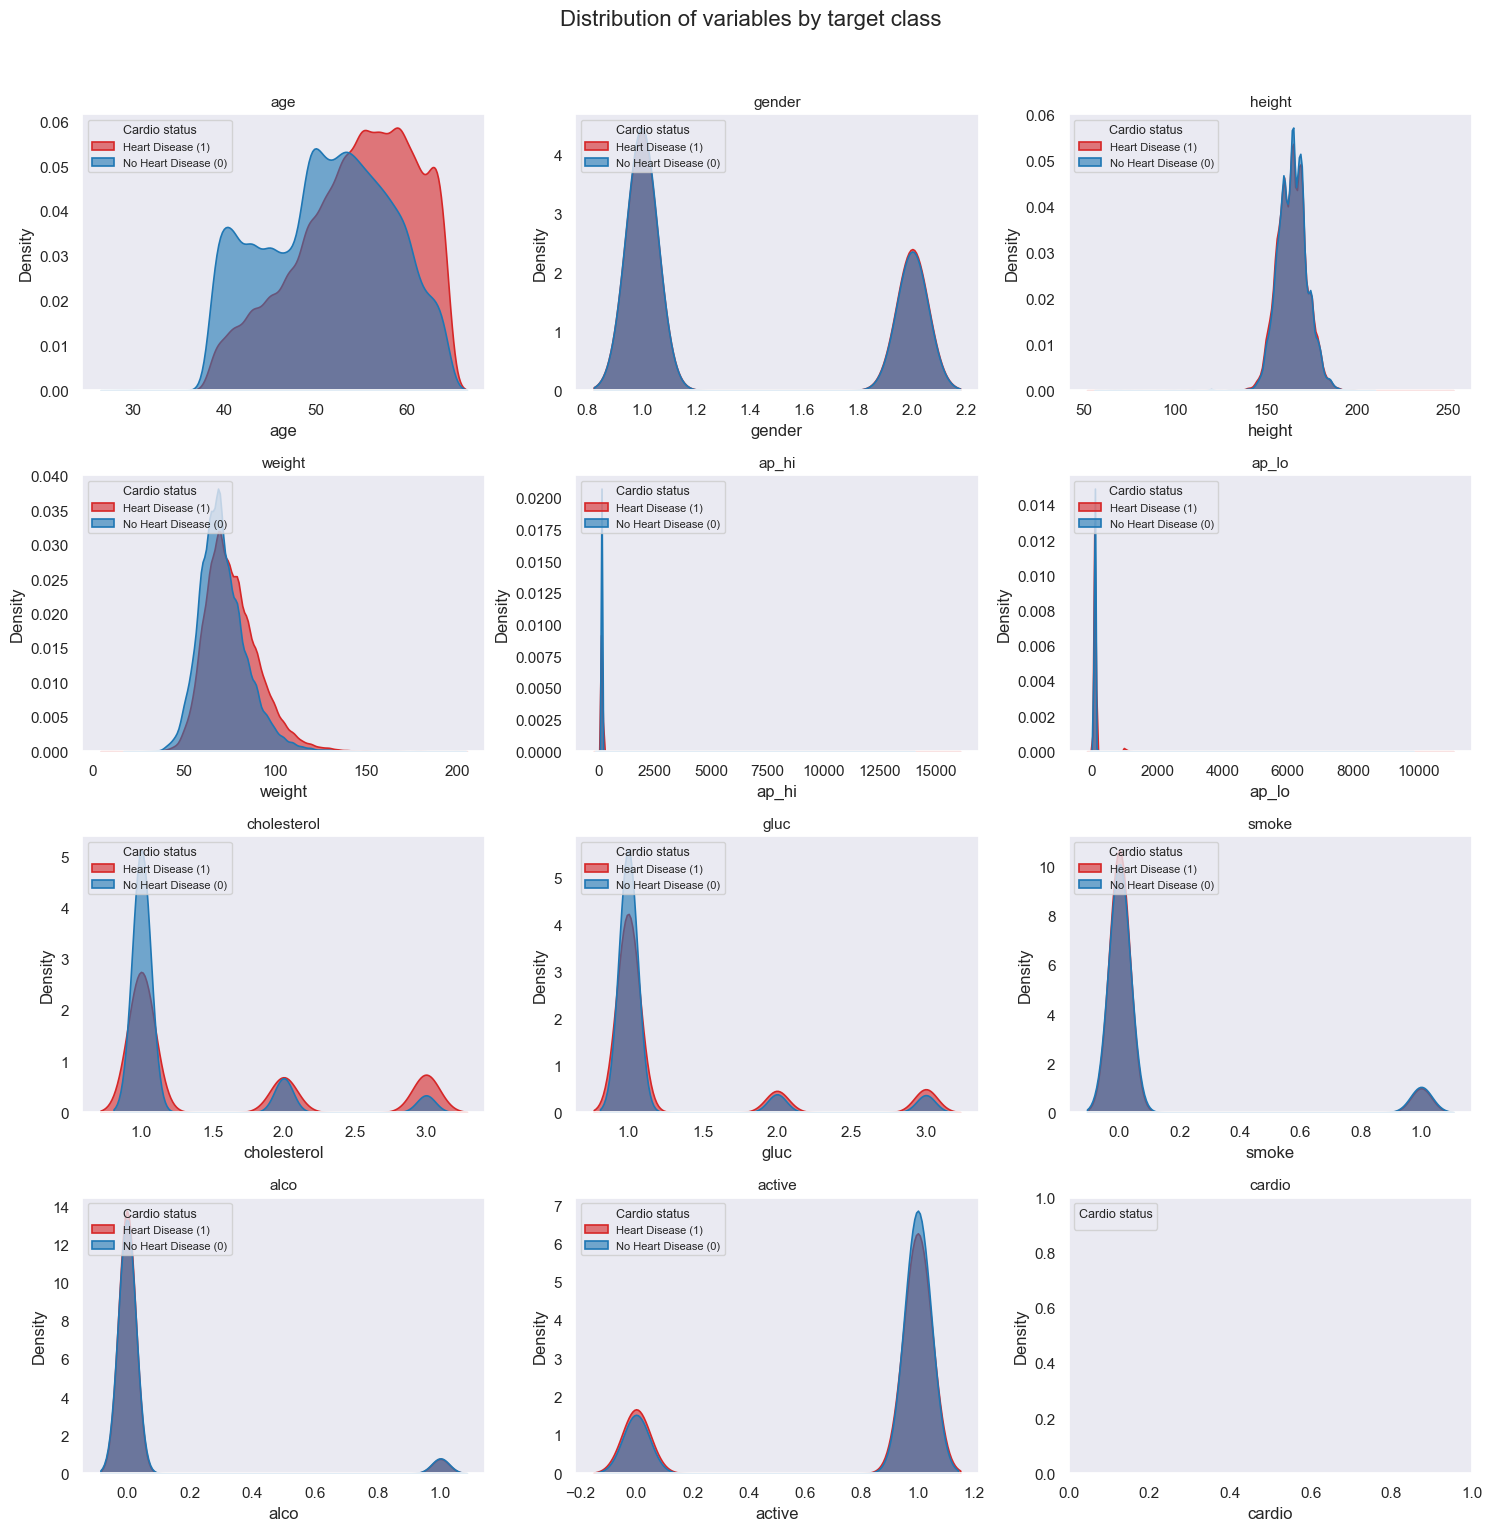

In [17]:
# visualize distributions of variables by target class
target_col = "cardio" 

fig, axes = plt.subplots(nrows=len(cols) // 3, ncols=3, figsize=(15,15))
axes = axes.flatten()


palette = {0: "#1f77b4", 1: "#d62728"}  # blue 0, red 1
labels_map = {0: "No Heart Disease (0)", 1: "Heart Disease (1)"}

# plot KDE for each column
for i, col in enumerate(cols):
    sns.kdeplot(
        data=df_clean, x=col, hue=target_col, fill=True,
        common_norm=False, ax=axes[i], linewidth=1.2, palette=palette, alpha=0.6
    )
    axes[i].set_title(col, fontsize=11)
    axes[i].legend(
        title="Cardio status",
        labels=[labels_map[1], labels_map[0]],
        loc="upper left",
        fontsize=8,
        title_fontsize=9
    )


fig.suptitle("Distribution of variables by target class", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


#### **Correlation structure**  
Feature correlations are generally weak, suggesting low multicollinearity — good for tree-based methods like XGBoost.  
- The strongest relation appears between **height** and **weight** (moderate positive).  
- **ap_hi** and **ap_lo** show mild correlation, expected from systolic/diastolic linkage.  
- All other pairs remain near zero.  

→ This means each variable likely adds independent information to the model, and dimensionality reduction isn’t necessary.

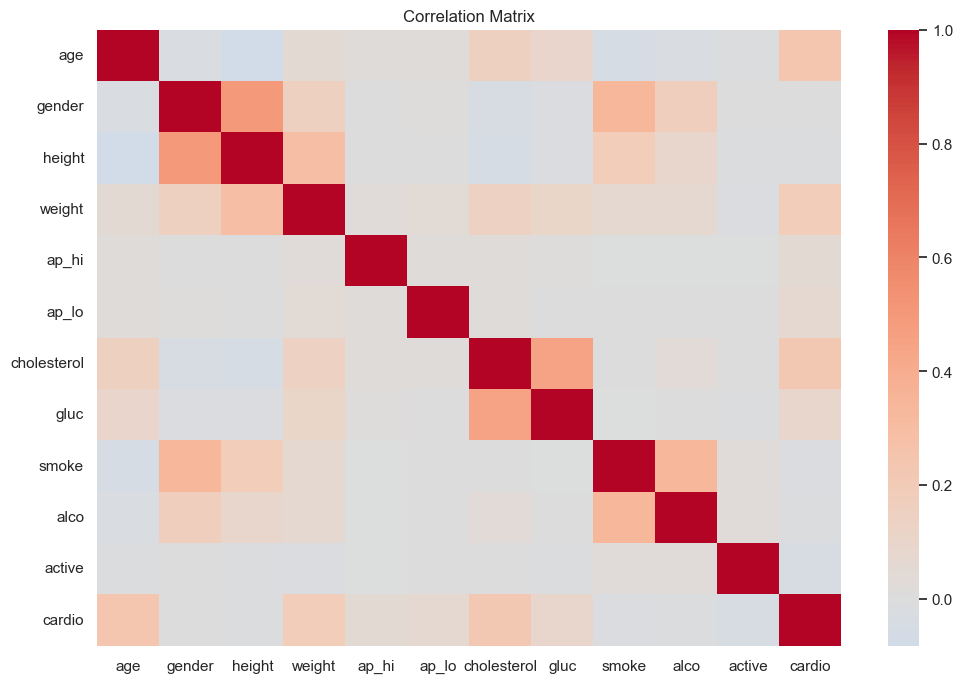

In [18]:
corr = df_clean.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

### 4. Modeling – Why XGBoost here 

We use XGBoost as a strong baseline that handles non-linear interactions out-of-the-box.
Given clean numeric inputs, a simple configuration suffices; heavy feature engineering isn’t necessary.

In [19]:
# prepare data for modeling
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [20]:
# base model
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### 5. Evaluation – What matters 

The model achieves an **AUC of approximately 0.80**, indicating good discriminative ability between positive and negative classes, even if the raw accuracy (~0.74) appears moderate.  
This means the model ranks patients with and without cardiovascular disease correctly most of the time, independent of a fixed threshold.

From the confusion matrix (using the 0.5 default cutoff):
- **True Positives (bottom-right)**: 4,947 correctly identified disease cases.  
- **True Negatives (top-left)**: 5,427 correctly identified healthy cases.  
- **False Positives (top-right)**: 1,561, patients incorrectly flagged as diseased.  
- **False Negatives (bottom-left)**: 2,065, missed disease cases.

→ The model shows **balanced performance**, though with a slight preference toward **precision** rather than **recall** at this threshold.  
Given the dataset’s balanced nature, AUC is the most reliable single metric to assess generalization here — it confirms that the model’s ranking ability is strong, even if the classification threshold could still be tuned for different clinical goals.


Classification Report:

AUC:0.80
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6988
           1       0.76      0.71      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000



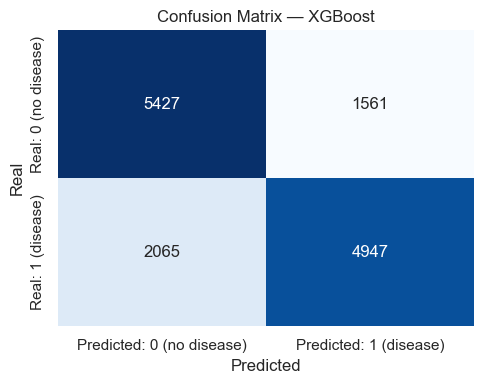

In [23]:
# predictions and evaluation
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

# detailed classification report
print("\nClassification Report:\n")
print(f'AUC:{roc_auc_score(y_test, y_prob):.2f}')
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted: 0 (no disease)", "Predicted: 1 (disease)"],
            yticklabels=["Real: 0 (no disease)", "Real: 1 (disease)"])
plt.title("Confusion Matrix — XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

### 6. Interpretation – Global & Local 

#### **XGBoost** Feature Importance:

Tree-based importance (by split frequency) shows:
- **Weight**, **height**, and **age** dominate early splits.  
- Blood pressure (`ap_hi`, `ap_lo`) also appears as key discriminants.  
- Lifestyle factors (`smoke`, `alco`, `active`) have weaker contributions — expected given their binary and self-reported nature.

→ This view reflects how often features are used, not their actual predictive impact.

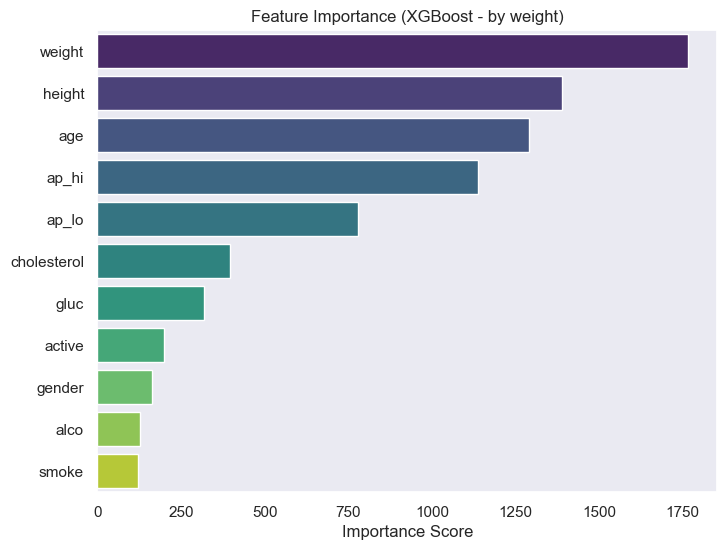

In [ ]:
# Feature Importance Plot
booster = xgb.get_booster()
importance = booster.get_score(importance_type="weight")

imp_df = (
    pd.DataFrame({"feature": importance.keys(), "importance": importance.values()})
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=imp_df, palette="viridis")
plt.title("Feature Importance (XGBoost - by weight)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.show()

#### **Global Feature Importance (SHAP, |mean value|):**  
This plot ranks features by their *average absolute SHAP value* (in log-odds), i.e., the average magnitude of each feature’s contribution to the model’s output across all test samples.

**What it shows**
- **ap_hi (systolic BP)** dominates the model’s decisions by a wide margin.  
- Next most influential are **age** and **cholesterol**; both contribute materially to risk ranking.  
- **weight** and **ap_lo (diastolic BP)** add secondary signal.  
- Lifestyle flags (**active**, **gluc**, **smoke**, **alco**) and **gender** have comparatively small global impact in this dataset.

**How to read it**
- Higher bars = larger *typical* impact on predictions (stronger driver of risk, on average).  
- This view is **magnitude-only** (|SHAP|). It does **not** show direction (whether high values increase or decrease risk).

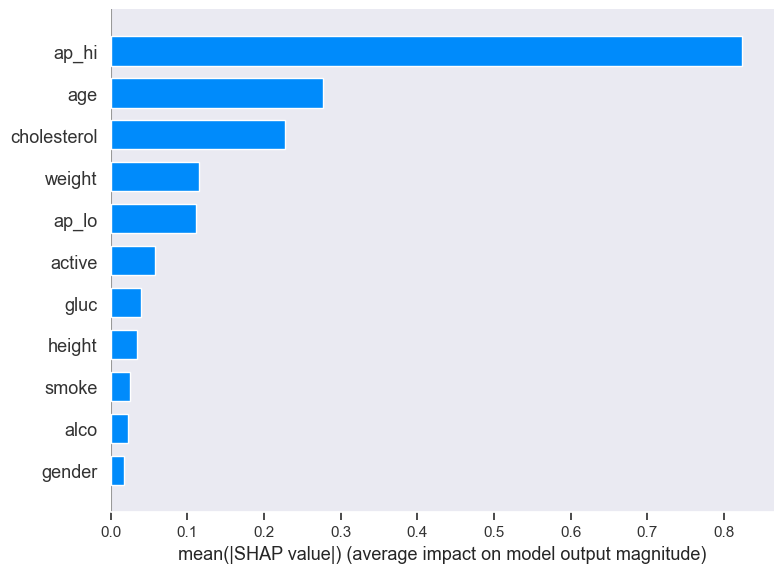

In [ ]:
# SHAP feature importance plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

#### **SHAP Summary** (Global impact):

SHAP values quantify how each feature influences the model’s log-odds output.

- **Systolic pressure (`ap_hi`)** is by far the strongest driver of predictions.  
  High values (red) push predictions toward disease; low values (blue) reduce risk.
- **Age** follows the same pattern: older patients increase disease probability.
- **Cholesterol** ranks third, confirming known medical relationships.

→ These attributions are more reliable than raw feature importance because SHAP considers feature interactions and directionality.

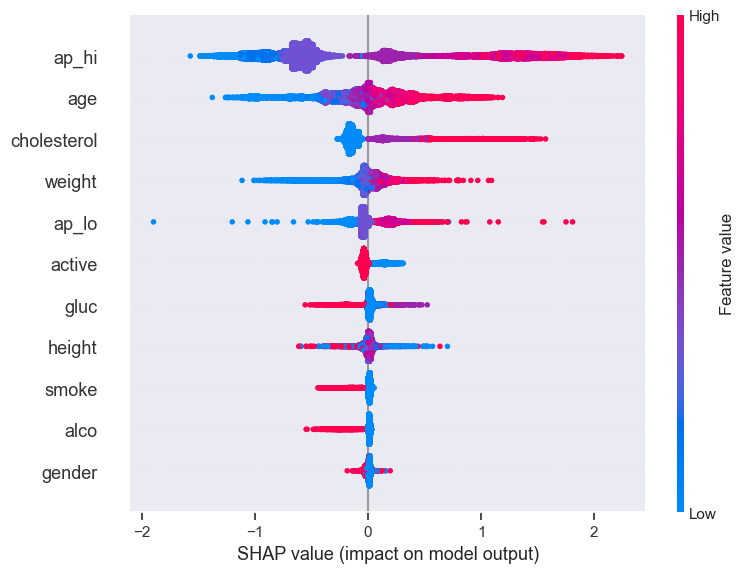

In [ ]:
# SHAP values computation and summary plot
explainer = shap.TreeExplainer(
    xgb,                     # XGBClassifier
    model_output="raw"       # output in log-odds space
)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


#### **SHAP Waterfall** (Local explanation):

Example: one patient (index = 7)
- The model predicts a mild positive risk (f(x) = 0.084).  
- `ap_hi` and `ap_lo` increase predicted risk (+0.24, +0.22).  
- `age` and `cholesterol` reduce it slightly (-0.25, -0.19), balancing the score.

→ Local SHAP analysis helps understand *why* a specific prediction was made,  
useful for clinical interpretability or individual case audit.

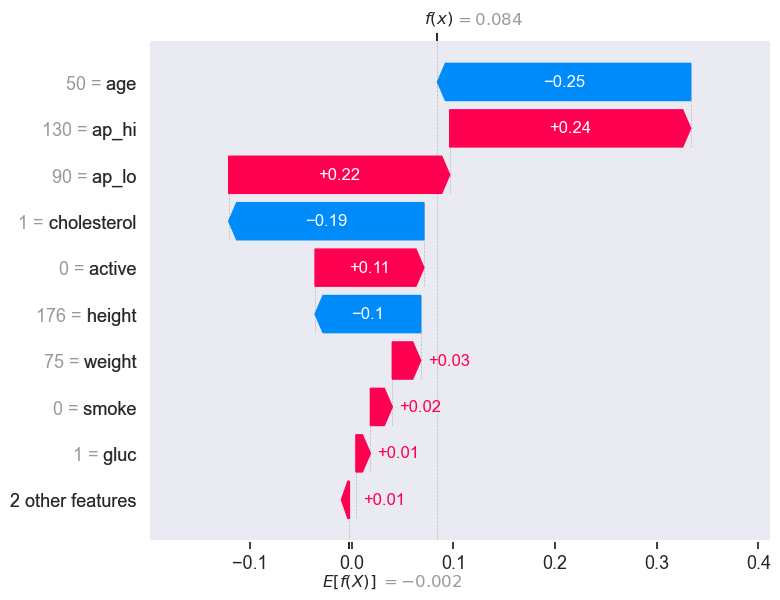

In [ ]:
# SHAP waterfall plot for a specific instance

i = 7
sv_row = explainer.shap_values(X_test.iloc[[i]])[0]
base = explainer.expected_value
shap.plots.waterfall(shap.Explanation(values=sv_row,
                                      base_values=base,
                                      data=X_test.iloc[i].values,
                                      feature_names=X_test.columns))

### 7. Reproducibility and Model Export

#### **Seed control**  
To make experiments reproducible, random seeds are fixed for Python, NumPy, and environment-level hashing.  
This ensures that data splits, model initialization, and training behavior remain deterministic.

In [59]:
import numpy as np
import random
import os

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

#### **Model persistence**  
The trained XGBoost model is exported as a `.pkl` file alongside a small JSON file containing:  
- feature order  
- training/test shapes  
- performance metrics  
- random seed and creation timestamp  

These files enable consistent inference and experiment tracking later on.

In [61]:
import joblib, json, datetime, os

os.makedirs("models", exist_ok=True)

# save model
joblib.dump(xgb, MODEL_PATH)

# save metadata
metadata = {
    "created_at": str(datetime.datetime.now()),
    "model_type": "XGBoostClassifier",
    "features": list(X.columns),
    "target": "cardio",
    "train_shape": X_train.shape,
    "test_shape": X_test.shape,
    "metrics": metrics,
    "random_seed": 42
}

with open(META_PATH, "w") as f:
    json.dump(metadata, f, indent=2)

print("✅ Model and metadata saved successfully.")

✅ Model and metadata saved successfully.


#### **Reload test**  
Verifies that the serialized model can be reloaded and used for prediction.  
This ensures end-to-end consistency before deployment or integration with an API.

In [63]:
# reload and test
loaded_model = joblib.load(MODEL_PATH)
sample_pred = loaded_model.predict(X_test.iloc[:5])
print("Sample prediction:", sample_pred)

Sample prediction: [1 1 1 0 0]


#### **Environment snapshot**  
Captures library versions to ensure full reproducibility across environments.  
In production, these would be pinned inside a `requirements.txt` or `environment.yml`.

In [ ]:
# !pip freeze | grep -E "xgboost|shap|pandas|numpy|matplotlib|scikit-learn"